In [2]:
%load_ext autoreload
%autoreload 2

**<h2> Imports**

In [3]:
import numpy as np
import nibabel as nib
import sys
import os
from time import time, sleep
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

<h4>import additional scripts:

In [4]:
sys.path.append(os.path.dirname('../.'))
from scripts.integral_volume import (Point3d, IntegralVol, IntegralVolTest)
from scripts.niblack3d import Niblack3d
from scripts.multyprocess_utils import MultuProcCalc
from scripts.load_and_save import (get_dcm_info, get_dcm_vol, vox_size2affine,
                                   load_nii_vol, save_vol_as_nii, raw2nifti)
from scripts.utils import print_img, print_imgs
from scripts.hessian_based import frangi_detect

<h4> Show efficiency

In [4]:
#IntegralVolTest()

**<h2>Load Data**

**<h4> DICOMDIR CT**

In [7]:
sample_name = "SE000007"
#path_to_dir = '/home/msst/Documents/medtech/KT/sorted'
path_to_dir = '/home/msst/Documents/medtech/data/MRA_data/neurosputnik/dcm/P1'
dcm_data = get_dcm_info(path_to_dir + '/' + sample_name + '/')
dcm_data.keys()

dict_keys(['Noname'])

In [8]:
data = dcm_data['Noname']
print(data['file_names'][0])
print(data['file_names'][10])

IM000105
IM000052


<h4> Make sorter for filenames

In [9]:
sorted_names = sorted(data['file_names'],
                     key=lambda item: (int(item[2:])))
data['file_names'] = sorted_names
print(sorted_names)

['IM000001', 'IM000002', 'IM000003', 'IM000004', 'IM000005', 'IM000006', 'IM000007', 'IM000008', 'IM000009', 'IM000010', 'IM000011', 'IM000012', 'IM000013', 'IM000014', 'IM000015', 'IM000016', 'IM000017', 'IM000018', 'IM000019', 'IM000020', 'IM000021', 'IM000022', 'IM000023', 'IM000024', 'IM000025', 'IM000026', 'IM000027', 'IM000028', 'IM000029', 'IM000030', 'IM000031', 'IM000032', 'IM000033', 'IM000034', 'IM000035', 'IM000036', 'IM000037', 'IM000038', 'IM000039', 'IM000040', 'IM000041', 'IM000042', 'IM000043', 'IM000044', 'IM000045', 'IM000046', 'IM000047', 'IM000048', 'IM000049', 'IM000050', 'IM000051', 'IM000052', 'IM000053', 'IM000054', 'IM000055', 'IM000056', 'IM000057', 'IM000058', 'IM000059', 'IM000060', 'IM000061', 'IM000062', 'IM000063', 'IM000064', 'IM000065', 'IM000066', 'IM000067', 'IM000068', 'IM000069', 'IM000070', 'IM000071', 'IM000072', 'IM000073', 'IM000074', 'IM000075', 'IM000076', 'IM000077', 'IM000078', 'IM000079', 'IM000080', 'IM000081', 'IM000082', 'IM000083', 'IM

In [10]:
brain_vol, vox_size = get_dcm_vol(path_to_dir + '/' + sample_name + '/', data)
print("brain_vol.shape:", brain_vol.shape)
print("vox_size:", vox_size)
print(type(brain_vol[0,0,0]))
#vox_size = ("0.423828125", "0.423828125", '0.3')
vox_size = ('0.26041665673256', '0.26041665673256', '0.4')

brain_vol.shape: (768, 696, 168)
vox_size: ('0.26041665673256', '0.26041665673256', '16.0')
<class 'numpy.uint16'>


**<h4> padding / deleting slices**
    

In [202]:
#deleting
new_vol = np.zeros((brain_vol.shape[0],
                    brain_vol.shape[1],
                    512), dtype=type(brain_vol[0,0,0]))
new_vol = brain_vol[:, :, -512:]
brain_vol = new_vol
print(brain_vol.shape)
print(type(brain_vol[0,0,0]))
print(brain_vol.sum())
print(brain_vol.mean())

(512, 512, 512)
<class 'numpy.int16'>
-106503612200
-793.5137465596199


In [78]:
#padding
n_pad_slices = 25

new_vol = np.zeros((brain_vol.shape[0],
                    brain_vol.shape[1],
                    brain_vol.shape[2]+n_pad_slices), dtype=type(brain_vol[0,0,0]))
new_vol[:, :, (n_pad_slices//2):brain_vol.shape[2]+(n_pad_slices//2)] = brain_vol
brain_vol = new_vol
print(brain_vol.shape)
print(type(brain_vol[0,0,0]))
print(brain_vol.sum())
print(brain_vol.mean())


(512, 512, 281)
<class 'numpy.int16'>
-12668010063
-171.9737485702352


In [11]:
path_to_save_head = '/home/msst/Documents/medtech/data/MRA_data/neurosputnik/converted/' + sample_name + ".nii.gz"
save_vol_as_nii(brain_vol, vox_size2affine(vox_size), path_to_save_head)

**<h4> NIFTI**

In [5]:
sample_name= "IXI020"

#sample_name = 'test'
path_to_nii_file = f"/home/msst/{sample_name}.nii.gz"

vol_file = nib.load(path_to_nii_file)
brain_vol = np.array(vol_file.dataobj)
print(brain_vol.shape)
print(brain_vol.dtype)

(512, 512, 100)
float32


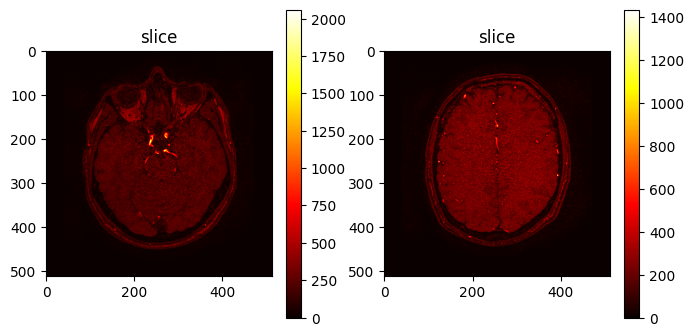

In [6]:
SHOW_SLICE = 31

fig, ax = plt.subplots(1, 2, figsize=(8, 4))    
print_img(brain_vol, ax[0], SHOW_SLICE, 'slice')    
print_img(brain_vol, ax[1], 90, 'slice')  

In [6]:
def create_hist(data, bins=1000):
    hist = np.histogram(data, bins, range=(data.min(), data.max()))
    counts, bins = hist
    return(counts, bins)

def plot_hist(counts, bins, range, bins_count=None, title="Graph"):
    plt.subplots(figsize=(6, 4)) 
    plt.hist(bins[:-1], bins_count, weights=counts, range=range)
    plt.title(title)
    plt.ylabel("counts", fontsize=14)
    plt.xlabel("value", fontsize=14)
    plt.show()

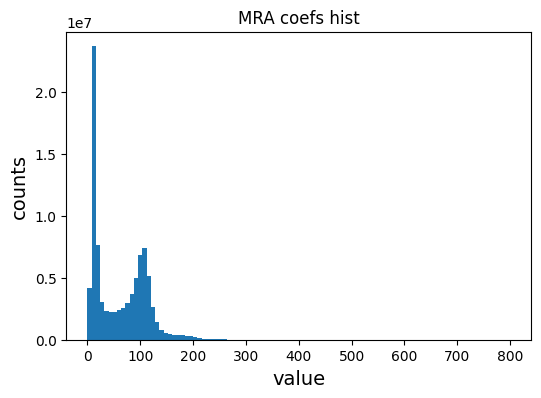

In [7]:
data = brain_vol
counts, bins = create_hist(data, 1000)
plot_hist(counts, bins, (data.min(), data.max()), 100, "MRA coefs hist")

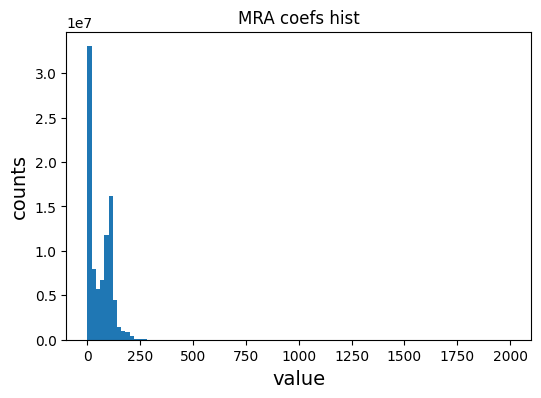

In [8]:
plot_hist(counts, bins, (0, 2000), 100, "MRA coefs hist")

**<h2> Binarization**

<h4> Research dispersion

In [12]:
window_size = (25, 25, 9)
coef_mu = 1.0
coef_sig = 0.8
coef_a = 10
Niblack = Niblack3d(vol=brain_vol,
                    window_size=window_size,
                    coef_mu=coef_mu, 
                    coef_sig=coef_sig,
                    coef_a=coef_a)

In [12]:
test_edges = [[100, 400],
                [100, 400],
                [0, 160]]
sigmas = Niblack.binarize(edges=test_edges, return_sigma=True)

In [13]:
sigmas = np.array(sigmas)
mu = sigmas[:, 0]
sigma = sigmas[:, 1]

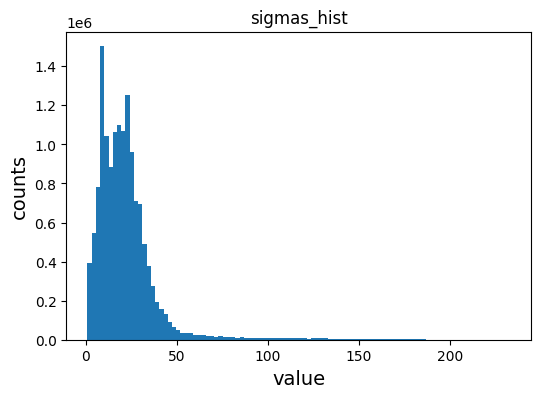

In [14]:
data = sigma
counts, bins = create_hist(data)
plot_hist(counts, bins, (data.min(), data.max()), 100, "sigmas_hist")

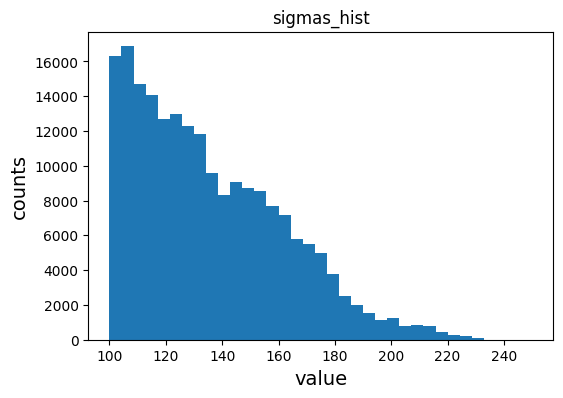

In [18]:
plot_hist(counts, bins, (100, 250), 35, "sigmas_hist")

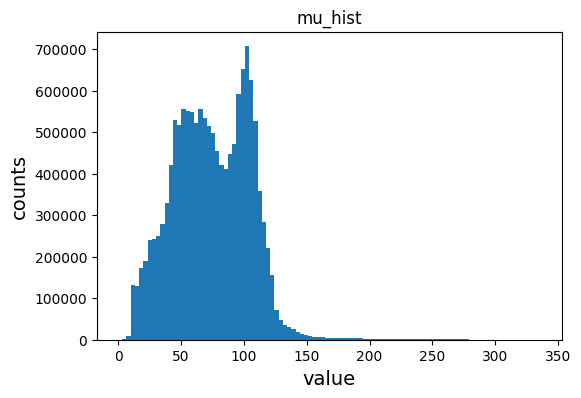

In [20]:
data = mu
counts, bins = create_hist(data)
plot_hist(counts, bins, (0, data.max()), 100, "mu_hist")

In [21]:
mu_agg = mu*1
mu_agg[mu_agg<0.000001] = 0.000001 #cut low mu
one_over_mu = 1/mu_agg 
mu_thresh = 100
one_over_mu[one_over_mu>1/mu_thresh] = 0 #cut low mu
sigma_over_high_mu = sigma * one_over_mu

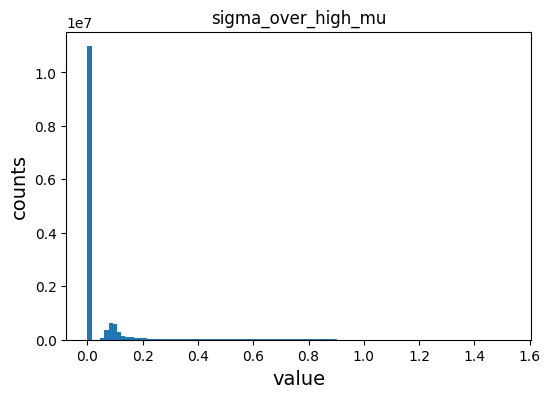

In [22]:
data = sigma_over_high_mu
counts, bins = create_hist(data, 1000)
plot_hist(counts, bins, (data.min(), data.max()), 100, "sigma_over_high_mu")

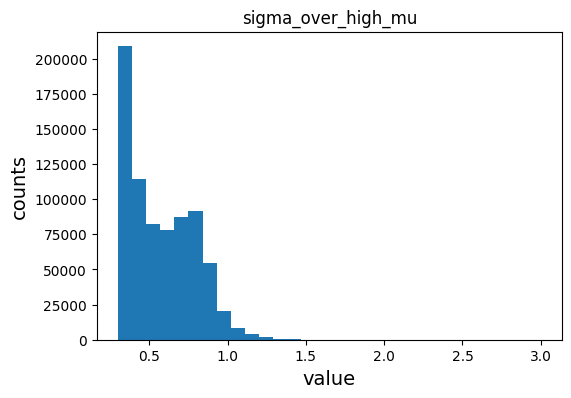

In [26]:
plot_hist(counts, bins, (0.3, 3), 30, "sigma_over_high_mu")

<h4> Calculations

In [13]:
set1 = {"window_size" : (51, 51, 17),
        "mu" : 1.0,
        "sig" : 0.8,
        "a" : 60}
set2 = {"window_size" : (41, 41, 15),
        "mu" : 1.0,
        "sig" : 1.0,
        "a" : 50}

set3 = {"window_size" : (31, 31, 13),
        "mu" : 1.0,
        "sig" : 1.2,
        "a" : 40}

set4 = {"window_size" : (21, 21, 11),
        "mu" : 1.0,
        "sig" : 1.4,
        "a" : 30}

sets = [set1, set2, set3]#, set4]

In [15]:
calcs = []
for set_ in sets:
    Niblack = Niblack3d(vol=brain_vol,
                    window_size=set_["window_size"],
                    coef_mu=set_["mu"], 
                    coef_sig=set_["sig"],
                    coef_a=set_["a"],
                    thresh=None,
                    weights_out=True,
                    min_ratio=0.9)
    calcs.append(MultuProcCalc(Niblack, num_workers=8))

In [16]:
t = time()
niblack_outs = []
for calc in calcs:
    niblack_outs.append(calc.run())
    print("spend:", time() - t)
    t = time()

spend: 26.879189252853394
spend: 27.25821805000305
spend: 26.92687964439392


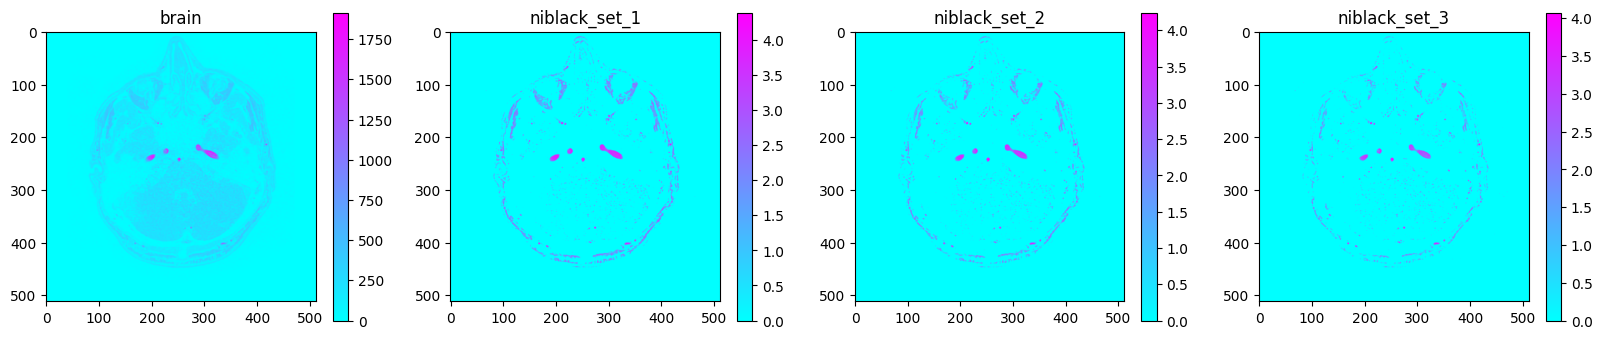

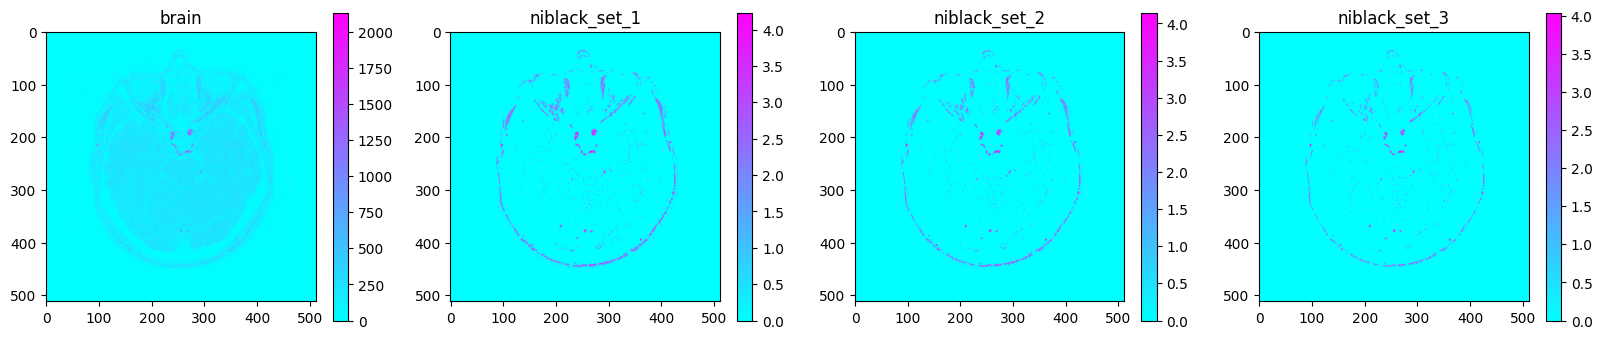

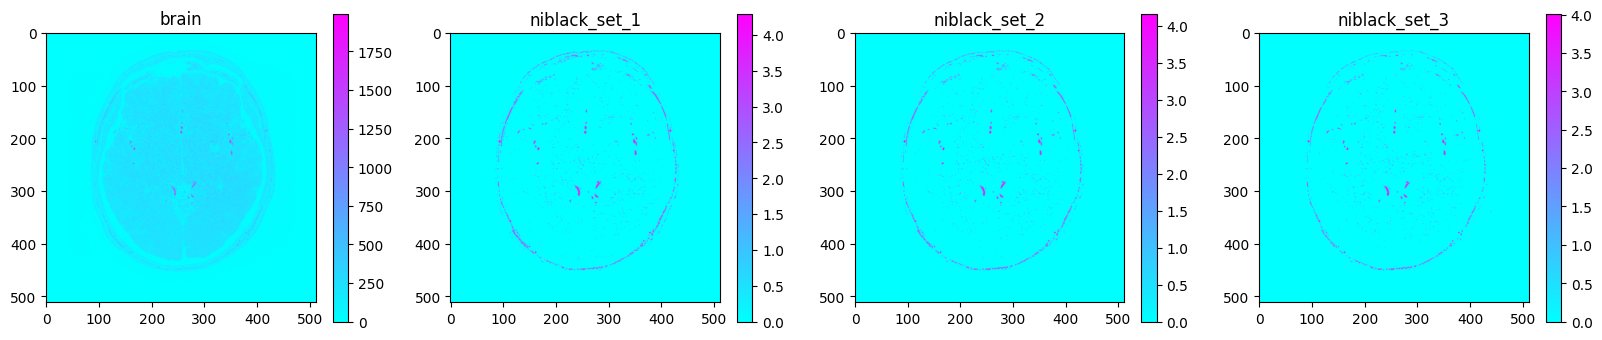

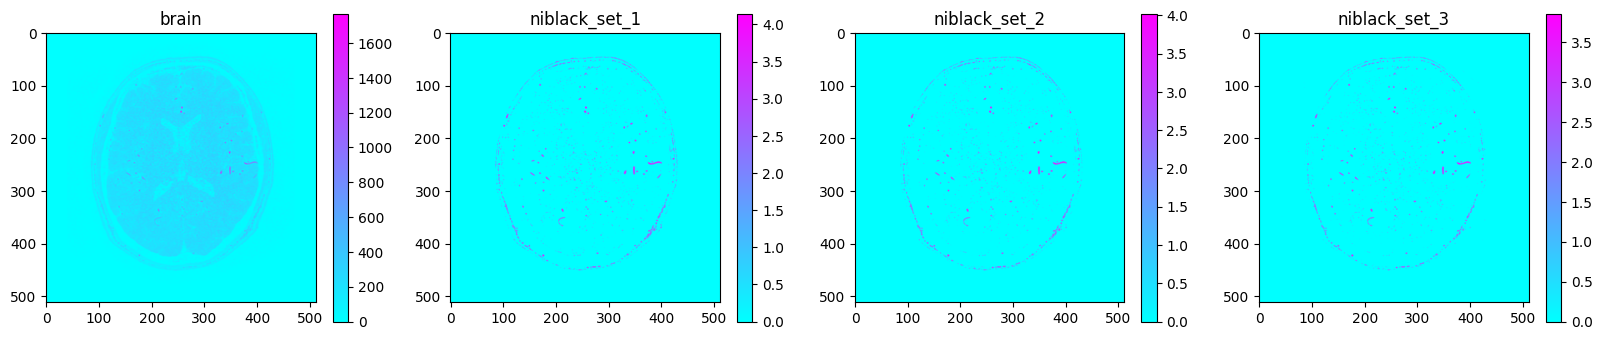

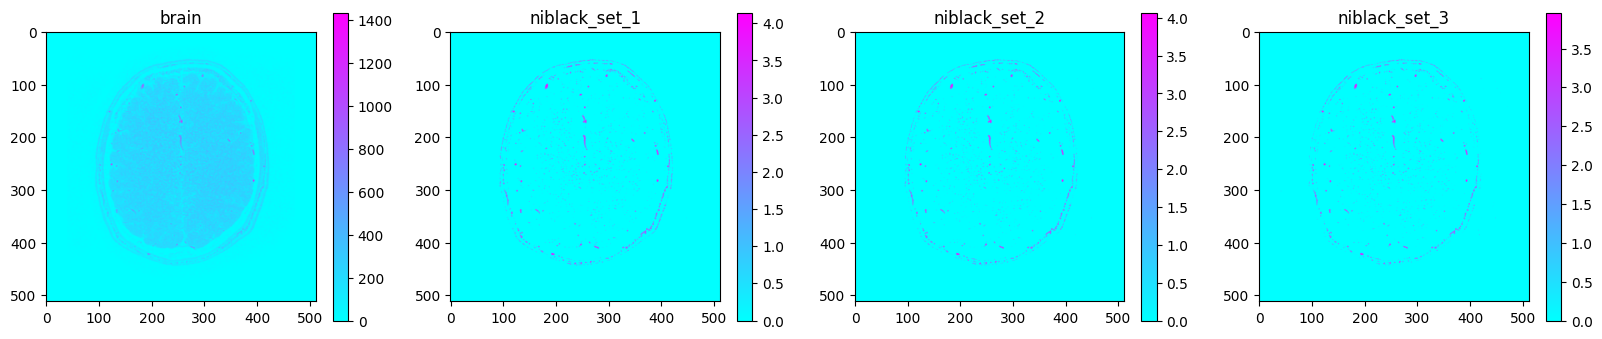

In [25]:
for idx in range(10, 100, 20):    
    SHOW_SLICE = idx

    fig, ax = plt.subplots(1, 1+len(niblack_outs), figsize=(20, 4))    
    print_img(brain_vol, ax[0], slice_=idx, title='brain', cmap='cool')  
    for i, out in enumerate(niblack_outs):
        print_img(out, ax[i+1], slice_=idx, title=f'niblack_set_{i+1}', cmap='cool')    
    

In [23]:
niblack_out = np.max(np.array(niblack_outs), axis=0)

In [24]:
path_to_save = f"/home/msst/{sample_name}_niblack.nii.gz"
save_vol_as_nii(niblack_out, vol_file.affine, path_to_save)

path_to_save = f"/home/msst/{sample_name}_niblack_mult.nii.gz"
save_vol_as_nii(brain_vol*niblack_out, vol_file.affine, path_to_save)

In [13]:
Niblack = Niblack3d(vol=bin_vol,
                    window_size=(25,25,11),
                    coef_mu=1, 
                    coef_sig=1,
                    coef_a=0.5,
                    thresh=None,
                    weights_out=False)

calc = MultuProcCalc(Niblack, num_workers=8)
next_lvl_out = calc.run()

NameError: name 'next_lvl_out' is not defined

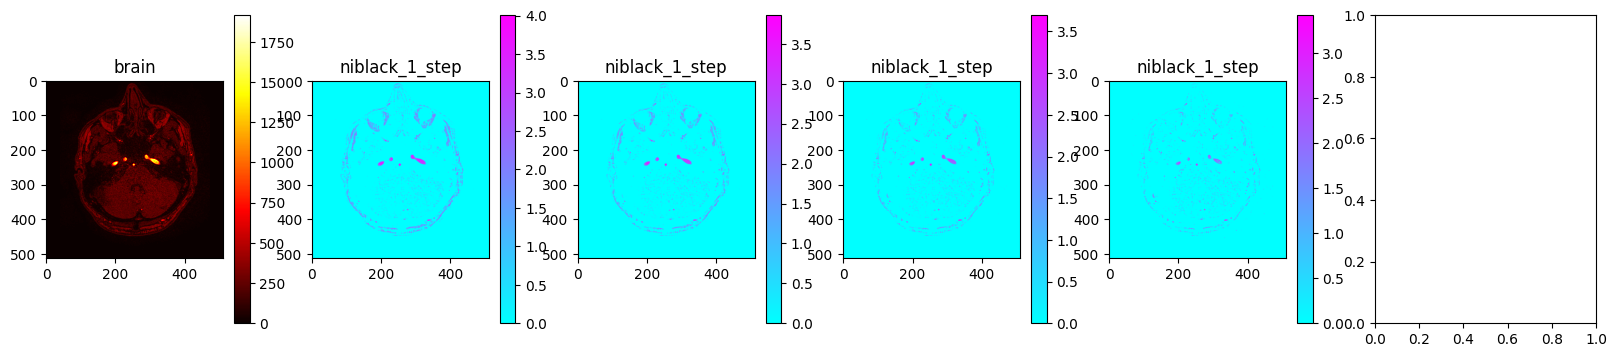

In [21]:
for idx in range(10, 100, 20):    
    SHOW_SLICE = idx

    fig, ax = plt.subplots(1, 2+len(outs), figsize=(20, 4))    
    print_img(brain_vol, ax[0], slice_=idx, title='brain')  
    for i, out in enumerate(outs):
        print_img(out, ax[i+1], slice_=idx, title='niblack_1_step', cmap='cool')  
    print_img(next_lvl_out, ax[i+2], slice_=idx, title='niblack_2_step', cmap='cool')  
    break

In [16]:
#data_dir = "/home/msst/Documents/medtech/data/MRA_data/neurosputnik/converted/P5"
data_dir = "/home/msst"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)


from datetime import datetime
now = datetime.now()

path_to_save_vessels = data_dir + f'/vessels_{now.time().hour}h{now.time().minute}m.nii.gz'

#save_vol_as_nii(bin_vol, vol_file.affine, path_to_save_vessels)
save_vol_as_nii(next_lvl_out, vol_file.affine, path_to_save_vessels)


**<h2> Hessian Based**

In [24]:
#out = frangi_detect(brain_vol[:, :, 50:100], sigma=5, k=4.6, alfa=0.01)
out = frangi_detect(brain_vol, sigma=5, k=4.6, alfa=0.01)

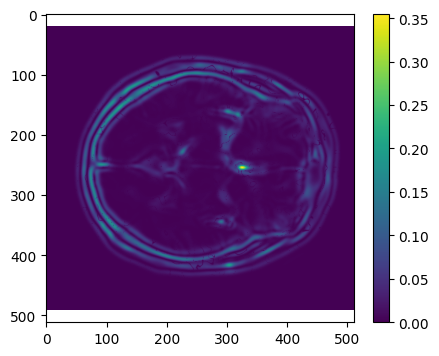

In [25]:
print_imgs([out], (5,5))

In [26]:
outs = []
for sigma in (2, 3, 5):
    out = frangi_detect(brain_vol, sigma=sigma, k=4.6, alfa=0.1)
    outs.append(out)

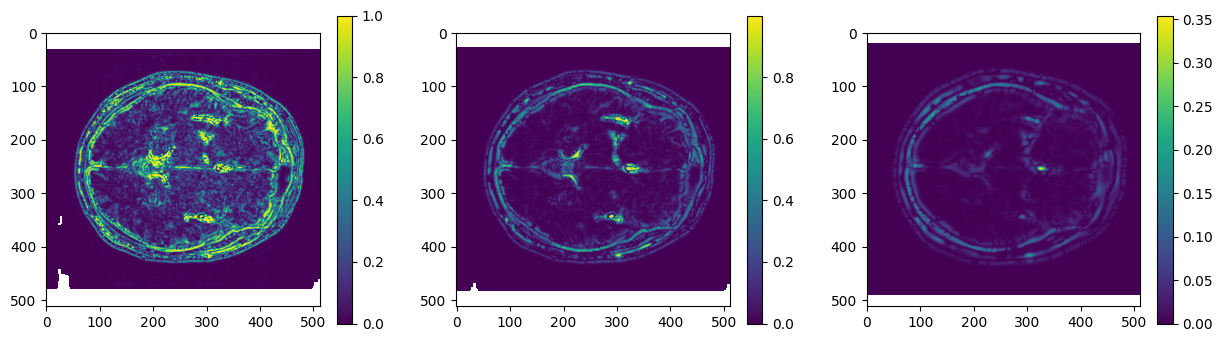

In [27]:
print_imgs(outs, (3,3))

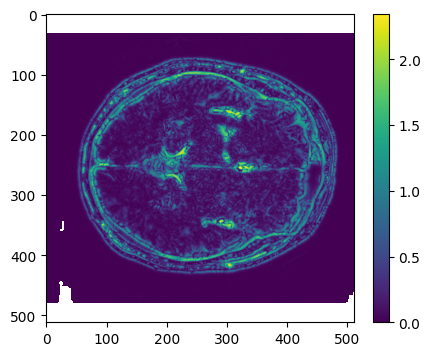

In [28]:
sum_out = np.zeros_like(outs[0])
for out in outs:
    sum_out+=out
print_imgs([sum_out], (3,3))

In [21]:
data_dir = "/home/msst/Documents/medtech/MRA_data/neurosputnik/converted"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

path_to_save_vessels = data_dir + f'/vessels_frangi.nii.gz'

save_vol_as_nii(sum_out, vol_file.affine, path_to_save_vessels)